# Finding Tissue-Intrinsic Coordinates in Small Intestines VisiumHD data

In [1]:
import sys
import os
import random
import math
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

import multi_gaston
from multi_gaston import data_processing,plotting

## Step 1: Pre-processing

Each sample input for Multi-GASTON should contain: 
- N_i x 2 spatial coordinate matrix,
- N_i x G gene expression matrix
where G=number of genes shared by all samples i=1,...,M, and N_i=number of spatial locations in the i-th sample.

For this visiumHD dataset, we manually cropped out 16 isolated villi from the 8um resolution, using each villus as a sample. These villi are stored in 'data/' for reference. 
We provide a helper function loading all the M input samples with the given sample names, as well as a function that logarithmizes and filters the raw gene expression.

In [2]:
slice_names = ['villus'+str(x) for x in range(1,17)]
data_dir = 'data/'

# Load all samples: first 2 columns should be 2D coordinates, remaining columns are expression counts
slices,S,A = data_processing.load_slices(data_dir, slice_names, if_compressed=True)

# For large gene sets, we process the data by filtering spots and genes, logarithmizing, and 
# identifying HVGs.
names_whole = pd.read_csv(data_dir+'filtered_features.tsv', sep="\t",header=None).to_numpy()[:,1]
slices,S,A_all_genes,A,names = data_processing.process_visiumHD(slices,S,A,names=names_whole)

for the 0th slice, S.shape = (180, 2), A.shape = (180, 19059)
for the 1th slice, S.shape = (204, 2), A.shape = (204, 19059)
for the 2th slice, S.shape = (203, 2), A.shape = (203, 19059)
for the 3th slice, S.shape = (209, 2), A.shape = (209, 19059)
for the 4th slice, S.shape = (181, 2), A.shape = (181, 19059)
for the 5th slice, S.shape = (186, 2), A.shape = (186, 19059)
for the 6th slice, S.shape = (178, 2), A.shape = (178, 19059)
for the 7th slice, S.shape = (191, 2), A.shape = (191, 19059)
for the 8th slice, S.shape = (179, 2), A.shape = (179, 19059)
for the 9th slice, S.shape = (187, 2), A.shape = (187, 19059)
for the 10th slice, S.shape = (242, 2), A.shape = (242, 19059)
for the 11th slice, S.shape = (234, 2), A.shape = (234, 19059)
for the 12th slice, S.shape = (187, 2), A.shape = (187, 19059)
for the 13th slice, S.shape = (216, 2), A.shape = (216, 19059)
for the 14th slice, S.shape = (255, 2), A.shape = (255, 19059)
for the 15th slice, S.shape = (215, 2), A.shape = (215, 19059)


To visiualize the samples before training, we plot a few gene expressions.

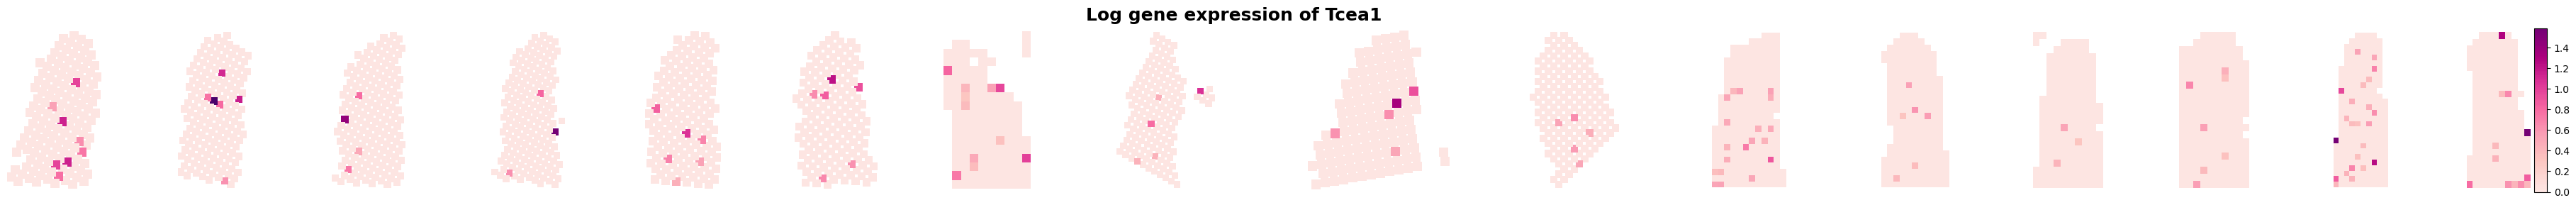

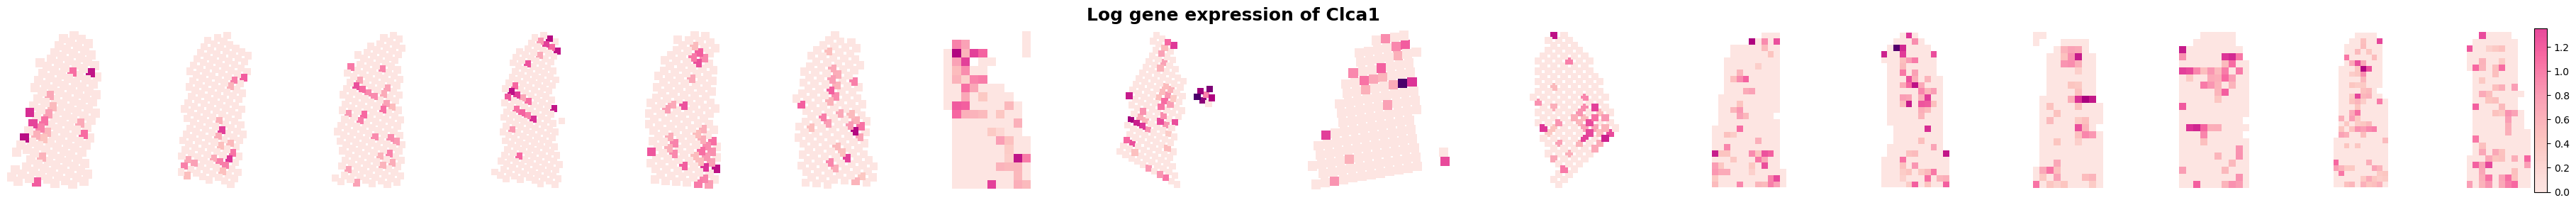

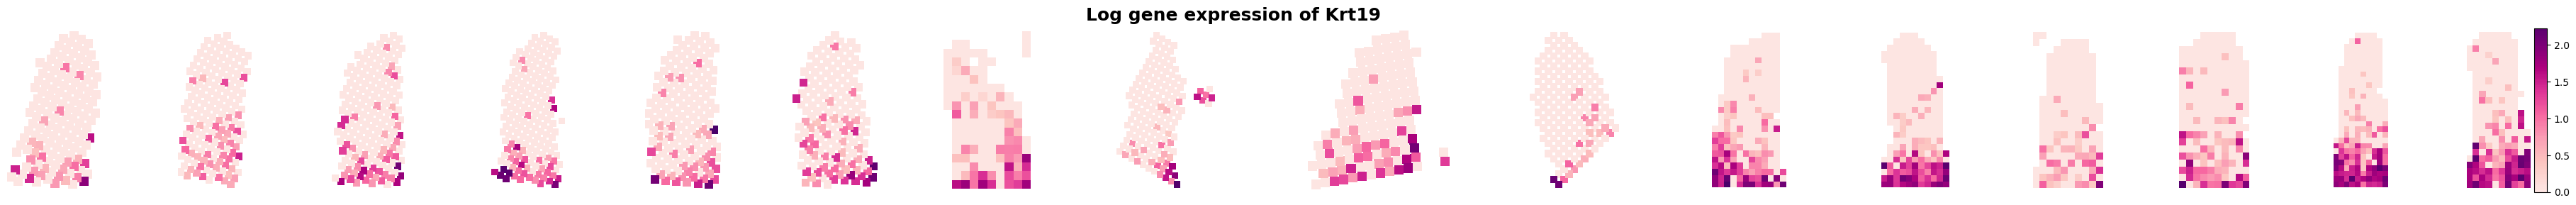

In [3]:
# plotting parameters to rotate and resize the 16 villi so they visually align
offset=[1.1,0.3,0.45,0.45,0.8,0.4,0.03,0.15,0.01,0.15,0.03,0.05,0.001,0.05,0.05,0.05]
angles=[150,150,150,150,-230,-230,90,60,100,135,180,180,180,180,180,180]

for i in [0,190,665]:
    plotting.plot_by_slice(S,A[:,i],slices,angles=angles,offset=offset,
                           title = f"Log gene expression of {names[i]}",colorbar_size=20,
                           contour=False,cmap='expression')


We include how to train the neural network with two options: (1) a command line script and (2) in a notebook. We typically train the neural network 10 different times, each with a different seed. 

We first transform the input matrices into torch tensors and z-score normalize.

In [5]:
# N x M feature matrix A and N x 2 coordinate matrix S are outputs from Step 1
S_torch, A_torch = data_processing.tensor_transform_inputs(S,A)

Next we train the neural network, once for each random initialization. 

In [17]:
######################################
# NEURAL NET PARAMETERS (USER CAN CHANGE)
# architectures are encoded as list, e.g. [20,20] means two hidden layers of size 20 hidden neurons
coord_arch=[80] # architecture for tissue-intrinsic coordinate function d(x,y) : R^2 -> R^K 
exp_arch=[] # architecture for expression function h(d(x,y)) : R^K -> R^G, in this data we expect 
                # individual gene expression to vary linearly along spatial axes, so we learn linear 
                # expression function.
K=2 # number of tissue-intrinsic coordinates to learn
lasso_coefficients =  [0.001,0.004,0.007,0.01]


num_epochs = 100
# 20000 # number of epochs to train NN (NOTE: it is sometimes beneficial to train longer)
checkpoint = 5000 # save model after number of epochs = multiple of checkpoint
!mkdir -p 16_villi
save_dir = '16_villi' # folder to save model runs
schedule = "constant"
num_restarts = 5

######################################

In [18]:
from multi_gaston import multi_gaston

seed_list=range(num_restarts)
for lasso in lasso_coefficients:
    print(f'training neural network for lasso = {lasso}')
    for seed in seed_list:
        print(f'\tseed = {seed}')
        out_dir_seed=f"{save_dir}/lasso{lasso}/rep{seed}/"
        os.makedirs(out_dir_seed, exist_ok=True)
        mod, loss_list, lasso_loss, loss_slices = multi_gaston.train(S_torch, A_torch,
                              S_hidden_list=coord_arch, A_hidden_list=exp_arch,
                              A_linear=True, lasso_lambda=lasso, K = K, slices=slices,
                              epochs=num_epochs, checkpoint=checkpoint, 
                              SAVE_PATH=out_dir_seed, schedule=schedule, seed=seed)

training neural network for lasso = 0.001
	seed = 0
	seed = 1
	seed = 2
	seed = 3
	seed = 4
training neural network for lasso = 0.004
	seed = 0
	seed = 1
	seed = 2
	seed = 3
	seed = 4
training neural network for lasso = 0.007
	seed = 0
	seed = 1
	seed = 2
	seed = 3
	seed = 4
training neural network for lasso = 0.01
	seed = 0
	seed = 1
	seed = 2
	seed = 3
	seed = 4


## Step 3: Process neural network output

If you use the model trained above, then figures will closely match the manuscript --- but not exactly match --- due to PyTorch non-determinism in seeding (see https://github.com/pytorch/pytorch/issues/7068 ). 

We also include the model used in the paper for reproducibility.

### Visualize tissue-intrinsic coordinates

We first plot the tissue-intrinsic coordinates learned in each trial, which will assist with selecting the best trial. To match the results and plots used in the paper, we also load the best tissue-intrinsic coordinates learned.

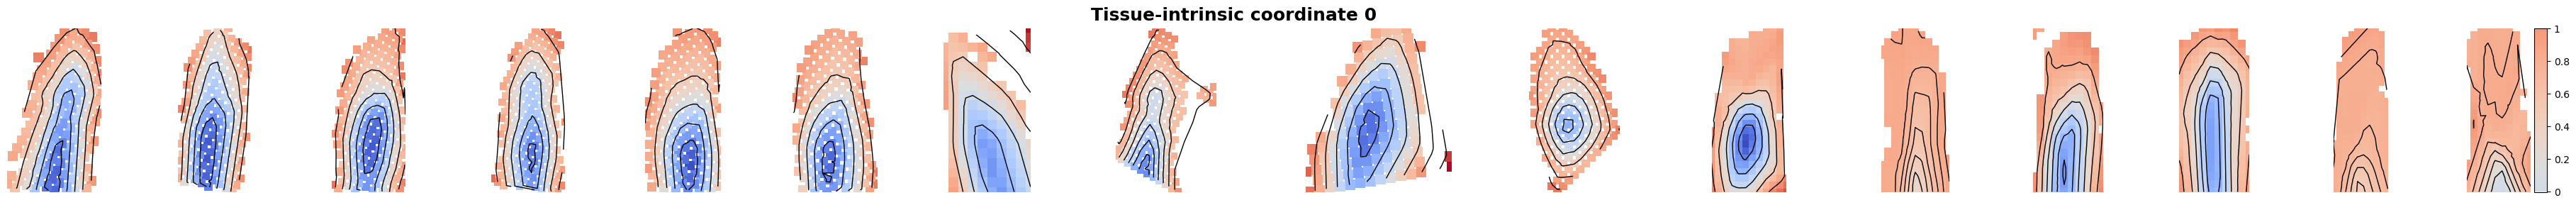

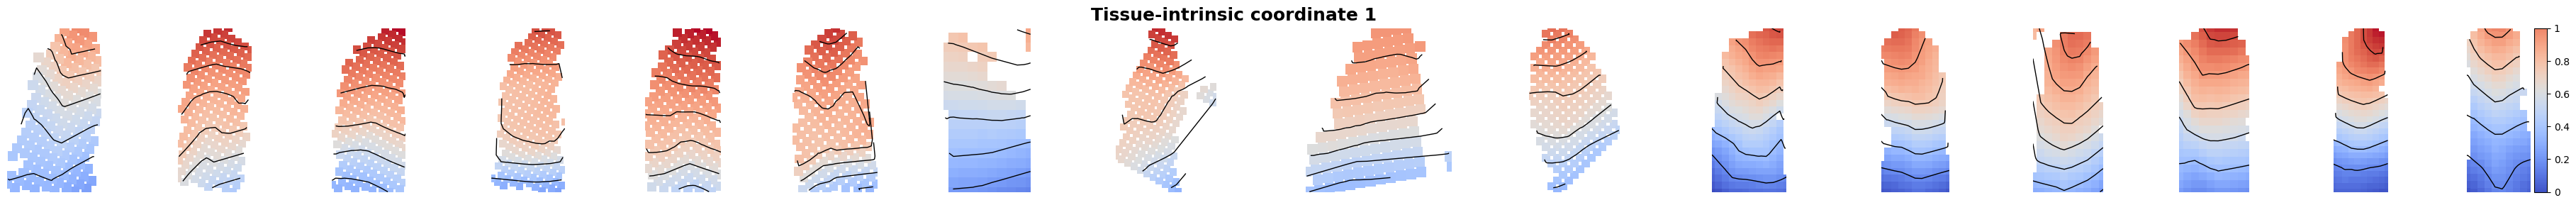

In [19]:
# MODEL TRAINED ABOVE
for lasso in lasso_coefficients:
    out_dir = save_dir+f'/lasso{lasso}/coordinates_all_trials'
    os.makedirs(out_dir, exist_ok=True)
    for seed in range(num_restarts):
        out_dir_seed=save_dir+f'/lasso{lasso}/rep{seed}/'
        coordinates=np.loadtxt(out_dir_seed+'coordinate.txt')
        loss = np.load(out_dir_seed+'loss_list.npy')[-1]
        lasso_loss = np.load(out_dir_seed+'lasso_loss.npy')[-1]
        tru_loss = loss - lasso_loss
        for k in range(K):
        # Since we learned multiple tissue-intrinsic coordinates, we plot each
        # coordinate one by one
            coordinate = plotting.normalize(coordinates[:,k],1)
            plotting.plot_by_slice(S,coordinate,slices,angles=angles,offset=offset,
                                   title = f"Tissue-intrinsic coordinate {k}",
                                   colorbar_size=20,colorbar_ticks=True,
                                   contour_levels=6,linewidths=1,
                                   save_dir=out_dir+f'/loss{tru_loss:.4g}_trial{seed}_coordinate{k}.png')

# TO MATCH PAPER FIGURES
coordinates=np.loadtxt(f"paper_results/loss0.03569_exp0.03339_nhs80_nhalin_trial0_lasso0.007_coordinate.txt")
for k in range(K):
    coordinate = plotting.normalize(coordinates[:,k],1)
    plotting.plot_by_slice(S,coordinate,slices,angles=angles,offset=offset,
                           title = f"Tissue-intrinsic coordinate {k}",
                           colorbar_size=20,colorbar_ticks=True,
                           contour_levels=6,linewidths=1)

Through visual assessment, we can clearly identify that the first tissue-intrinsic coordinate describes the lamina propria(LP)-epithelium apical axis, while the second tissue-intrinsic coordinate approximates the crypt-villus tip axis. We scale the two learned coordinates, making sure the minimum coordinate values correspond to the LP and crypt area, respectively. 

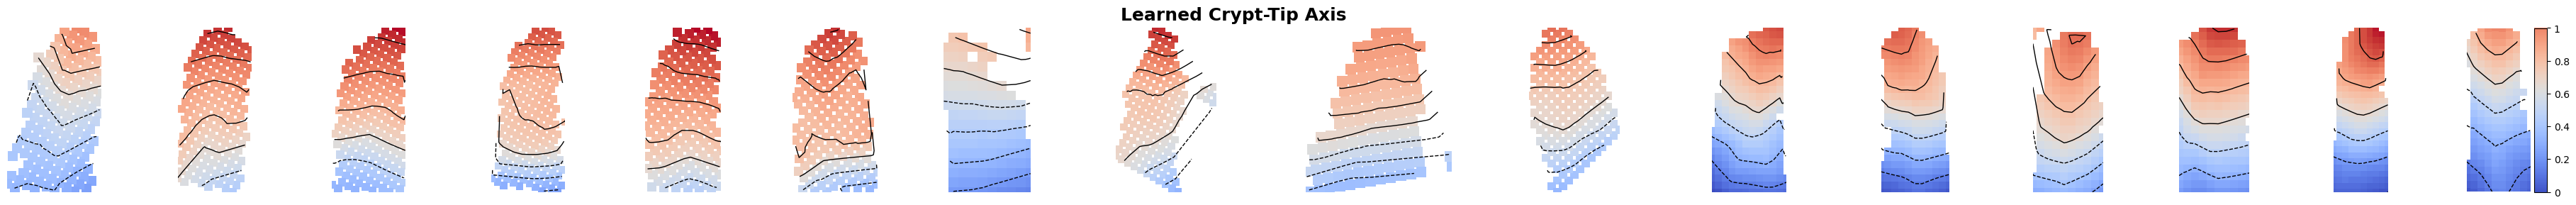

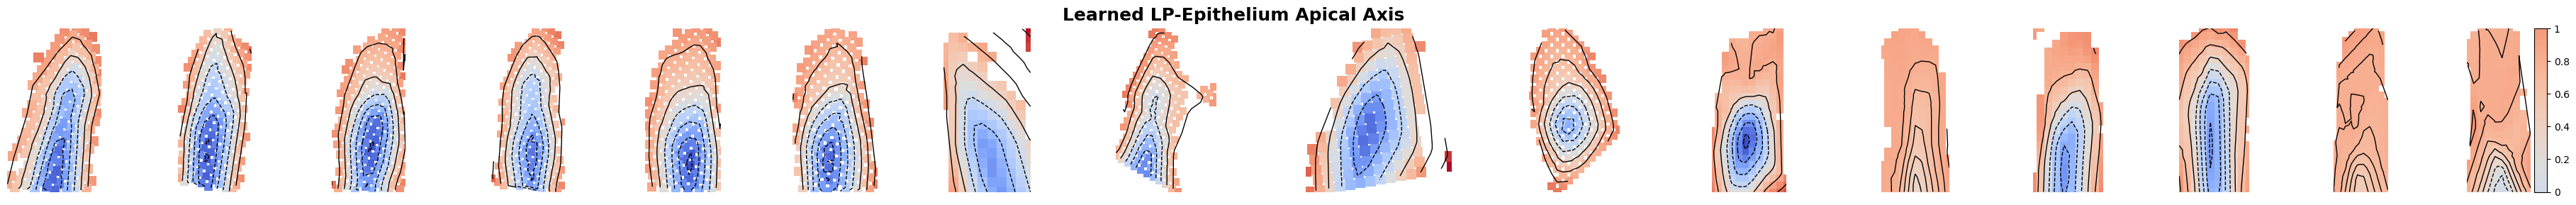

In [8]:
# Using marker genes to invert the learned coordinates if needed
tip_marker = np.where(names_whole=='Apoa4')[0][0]
LP_marker = np.where(names_whole=='Igha')[0][0]
crypt_tip_coord, LP_apical_coord = coordinates[:,1],coordinates[:,0]
m, _ = np.polyfit(crypt_tip_coord, A_all_genes[:,tip_marker], 1)
if m<0: crypt_tip_coord = crypt_tip_coord*-1+1
m, _ = np.polyfit(LP_apical_coord, A_all_genes[:,LP_marker], 1)
if m>0: LP_apical_coord = LP_apical_coord*-1+1

# Save results
np.savetxt(save_dir+'/final_crypt_tip_coord.csv',crypt_tip_coord, delimiter=",")
np.savetxt(save_dir+'/final_LP_apical_coord.csv',LP_apical_coord, delimiter=",")
plotting.plot_by_slice(S,crypt_tip_coord,slices,angles=angles,offset=offset,
                       title = f"Learned Crypt-Tip Axis",colorbar_size=20,colorbar_ticks=True,
                       contour_levels=6,linewidths=1)
plotting.plot_by_slice(S,LP_apical_coord,slices,angles=angles,offset=offset,
                       title = f"Learned LP-Epithelium Apical Axis",colorbar_size=20,colorbar_ticks=True,
                       contour_levels=6,linewidths=1)

Lastly, we identify spatially variable genes (SVGs) by testing whether each highly expressed gene (out of the full gene list instead of the top 1000 HVGs identified) has non-zero slopes w.r.t. the learned tissue-intrinsic coordinates.

In [9]:
from multi_gaston import svg_fitting
# First, we compute the slopes and p-vales of all genes with UMI > 300
pw_fit_dict_crypttip = svg_fitting.pw_linear_fit(A_all_genes, np.zeros(A_all_genes.shape[0]), crypt_tip_coord,
                                             zero_fit_threshold=0,umi_threshold=300)
binning_output_crypttip = svg_fitting.bin_data(A_all_genes, np.zeros(A_all_genes.shape[0]), crypt_tip_coord,
                                           names_whole, num_bins_per_domain=[10],umi_threshold=300,
                                           idx_kept=None)
pw_fit_dict_LPapical = svg_fitting.pw_linear_fit(A_all_genes, np.zeros(A_all_genes.shape[0]), LP_apical_coord,
                                             zero_fit_threshold=0,umi_threshold=300)
binning_output_LPapical = svg_fitting.bin_data(A_all_genes, np.zeros(A_all_genes.shape[0]), LP_apical_coord,
                                           names_whole, num_bins_per_domain=[10],umi_threshold=300,
                                           idx_kept=None)
slopes_mat_crypttip,_,pval_mat_crypttip = pw_fit_dict_crypttip
slopes_mat_LPapical,_,pval_mat_LPapical = pw_fit_dict_LPapical


# Then, we identify SVGs by filtering UMI, significant slopes and small p-values
UMI_threshold = 300
UMI_filter= np.where(A_all_genes.sum(axis=0)>UMI_threshold)[0]
names_UMI = names_whole[UMI_filter]

pval_threshold = 1e-5
pval_filter_crypttip = np.bitwise_and(pval_mat_crypttip>=0,pval_mat_crypttip<pval_threshold).flatten()
pval_filter_LPapical = np.bitwise_and(pval_mat_LPapical>=0,pval_mat_LPapical<pval_threshold).flatten()

slope_q_crypttip=np.quantile(np.abs(slopes_mat_crypttip), 0.7,0)
slope_q_LPapical=np.quantile(np.abs(slopes_mat_LPapical), 0.85,0)
tip_genes= np.where(np.bitwise_and(pval_filter_crypttip,(slopes_mat_crypttip >slope_q_crypttip).flatten()))[0]
crypt_genes= np.where(np.bitwise_and(pval_filter_crypttip,(slopes_mat_crypttip <-slope_q_crypttip).flatten()))[0]
api_genes= np.where(np.bitwise_and(pval_filter_LPapical,(slopes_mat_LPapical >slope_q_LPapical).flatten()))[0]
LP_genes= np.where(np.bitwise_and(pval_filter_LPapical,(slopes_mat_LPapical <-slope_q_LPapical).flatten()))[0]


# Lastly, we sort the identified SVGs by their slopes w.r.t. the respective learned tissue-intrinsic coordinate
tip_genes = names_UMI[sorted(tip_genes, key=lambda i: np.abs(slopes_mat_crypttip[i]),reverse=True)]
crypt_genes = names_UMI[sorted(crypt_genes, key=lambda i: np.abs(slopes_mat_crypttip[i]),reverse=True)]
LP_genes = names_UMI[sorted(LP_genes, key=lambda i: np.abs(slopes_mat_LPapical[i]),reverse=True)]
api_genes = names_UMI[sorted(api_genes, key=lambda i: np.abs(slopes_mat_LPapical[i]),reverse=True)]

print(f'Top five tip-zonated genes identified are {tip_genes[:5]}.')
print(f'Top five crypt-zonated genes identified are {crypt_genes[:5]}.')
print(f'Top five LP-zonated genes identified are {LP_genes[:5]}.')
print(f'Top five apical-zonated genes identified are {api_genes[:5]}.')

100%|█████████████████████████████████████████████████████████| 844/844 [00:02<00:00, 297.76it/s]


Top five tip-zonated genes identified are ['Slc28a2' 'Ada' 'Ly6m' 'Clca4a' 'Apoa4'].
Top five crypt-zonated genes identified are ['Dmbt1' 'Pycard' 'Krt19' 'Fabp6' 'Lypd8'].
Top five LP-zonated genes identified are ['Iglc1' 'Igha' 'Jchain' 'Igkc' 'Igfbp3'].
Top five apical-zonated genes identified are ['Slc28a2' 'Ada' 'Clca4a' 'Ly6m' 'Apoa4'].


We visualize some of the identified genes by plotting their expression against the learned coordinates and their log expression over the 16 villi.

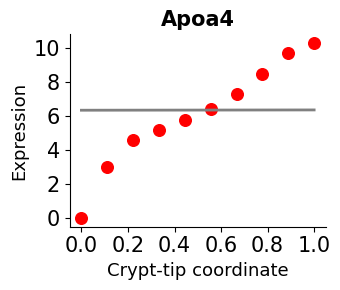

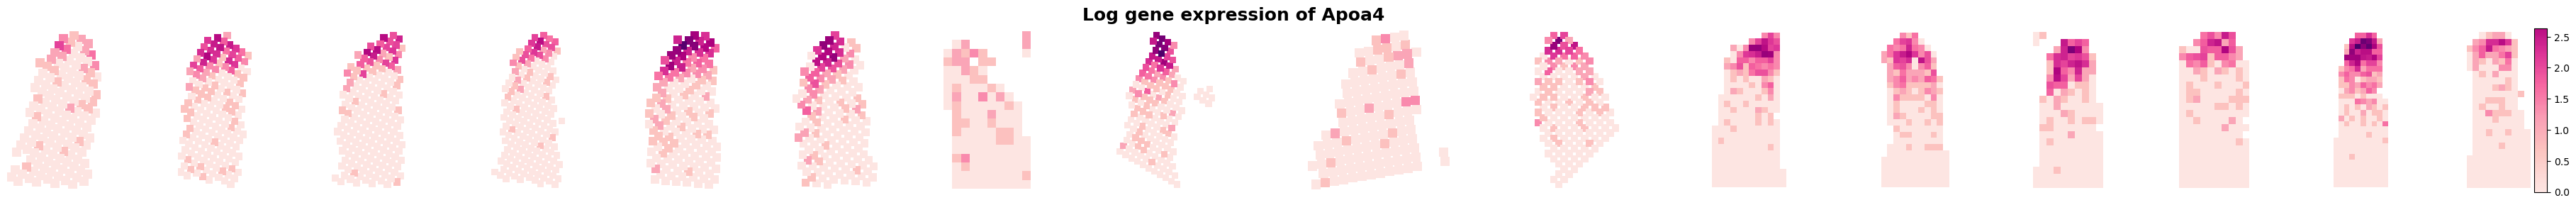

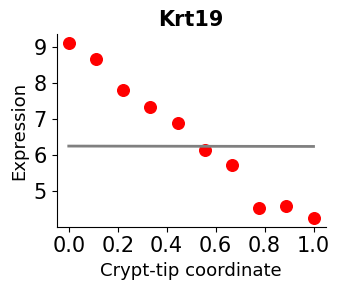

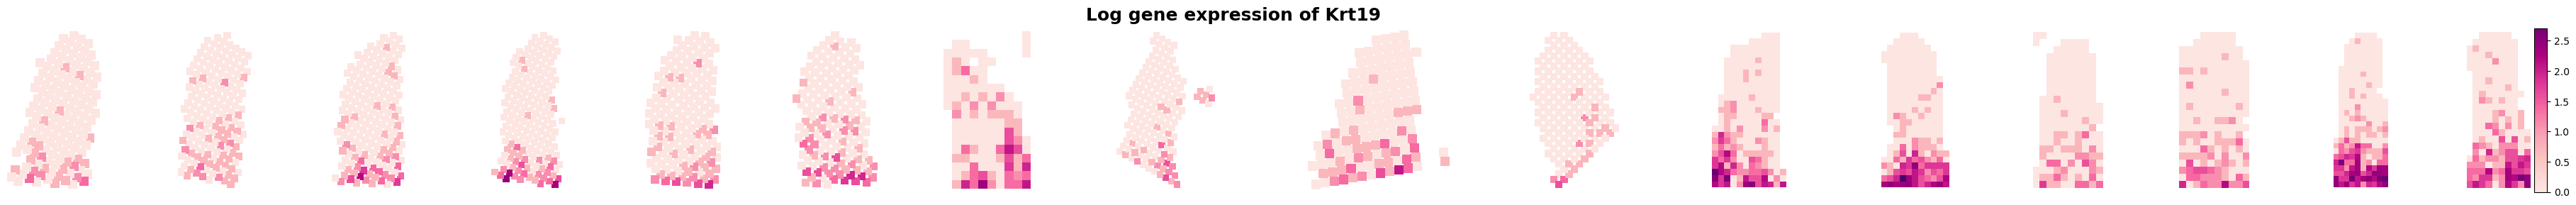

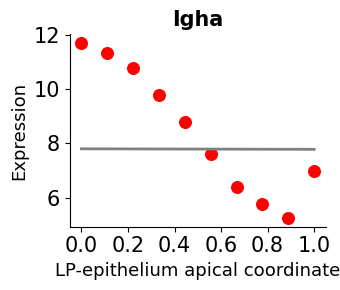

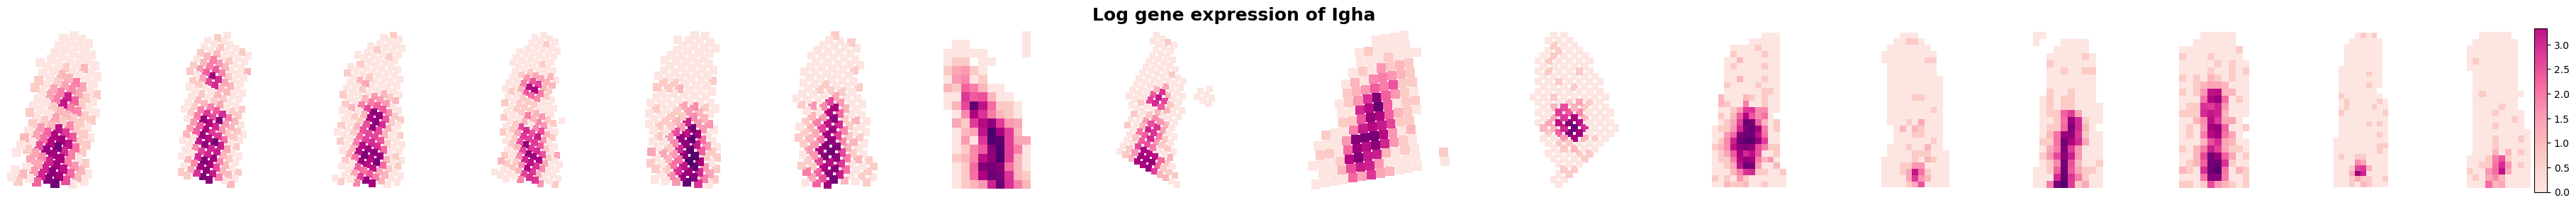

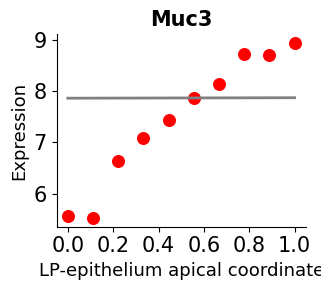

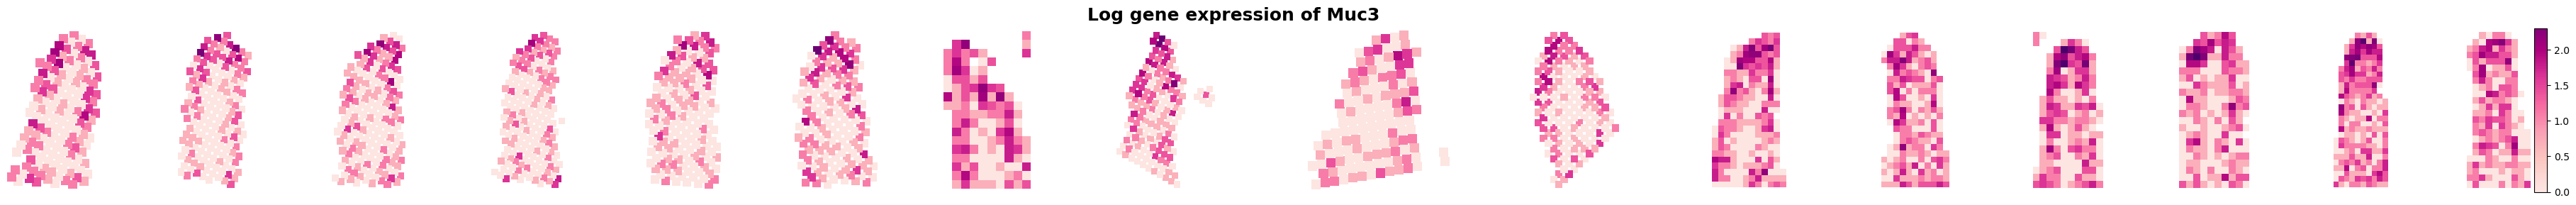

In [10]:
for n in ['Apoa4', 'Krt19']:
    svg_fitting.plot_gene_pwlinear(n, pw_fit_dict_crypttip, binning_output_crypttip, pt_size=70, 
                                            ticksize=15, figsize=(3.5,3), lw=2, colors=['red'])
    plt.title(n,fontsize=15,fontweight='demi')
    plt.ylabel('Expression',fontsize=13)
    plt.xlabel('Crypt-tip coordinate',fontsize=13)
    plt.tight_layout()
    plt.show()
    plt.close()
    log_exp=np.log(1+A_all_genes[:,np.where(names_whole==n)[0]])
    plotting.plot_by_slice(S,log_exp,slices,angles=angles,offset=offset,
                           title = f"Log gene expression of {n}",colorbar_size=20,
                           contour=False,cmap='expression')

for n in ['Igha', 'Muc3']:
    svg_fitting.plot_gene_pwlinear(n, pw_fit_dict_LPapical, binning_output_LPapical, pt_size=70, 
                                            ticksize=15, figsize=(3.5,3), lw=2, colors=['red'])
    plt.title(n,fontsize=15,fontweight='demi')
    plt.ylabel('Expression',fontsize=13)
    plt.xlabel('LP-epithelium apical coordinate',fontsize=13)
    plt.tight_layout()
    plt.show()
    plt.close()
    log_exp=np.log(1+A_all_genes[:,np.where(names_whole==n)[0]])
    plotting.plot_by_slice(S,log_exp,slices,angles=angles,offset=offset,
                           title = f"Log gene expression of {n}",colorbar_size=20,
                           contour=False,cmap='expression')
    